## Fruits classification using Transfer learning (ResNet model)

This notebook uses transfer learning on convoluted neural net "MobileNetV2" which was pre-trained on ImageNet, a dataset containing 14 million images and 1000 classes. 
This model will be used to classify different types of fruits, vegetables and nuts. 
* The dataset has 117576 training images of size 100x100 and 225 classes. 

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
# if importing data from kaggle

In [ ]:
pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

### 2. Training and Test data

In [2]:
data_path = "data/Training"
IMG_SIZE = (100,100)
BATCH_SIZE = 32 #number of images in a batch

train_data = image_dataset_from_directory(data_path, 
                                          batch_size=BATCH_SIZE, 
                                          image_size=IMG_SIZE, 
                                          shuffle=True,
                                          validation_split=0.2, 
                                          subset="training", 
                                          seed=42)

validation_data = image_dataset_from_directory(data_path, 
                                         batch_size=BATCH_SIZE, 
                                         image_size=IMG_SIZE, 
                                         shuffle=True, 
                                         validation_split=0.2,
                                         subset="validation", 
                                         seed=42)
# seed must match between train and validation set so it don't overlap

Found 117576 files belonging to 225 classes.
Using 94061 files for training.
Found 117576 files belonging to 225 classes.
Using 23515 files for validation.


* image_dataset_from_directory gives tf.data.dataset where each element is batch of images and labels
* shape: (images,labels); 
    * images: tensor of shape: (batch size, height, width, channel)
    * labels: tensor of shape: (batch size, ) eg: labels[1] = tf.Tensor(135, shape=(), dtype=int32)
* where batch size : number of images inside a single batch

Here batch size is 32, Each batch when unpacked has following shape: 
* images tensor of shape: (32, 100, 100, 3) 
* labels tensor of shape: (32, )

### 3. Visualising few training data

In [3]:
class_names = train_data.class_names
len(class_names) # 225 classes 

225

In [4]:
print("Sample class names in the data: ", class_names[0],",",class_names[50],",",class_names[-50])

Sample class names in the data:  Apple 10 , Cactus fruit 1 , Physalis 1


2025-11-18 21:07:30.952623: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


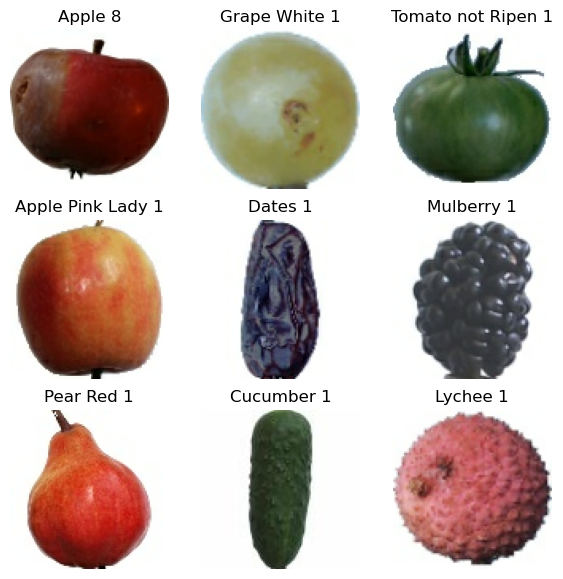

In [5]:
plt.figure(figsize=(7,7))

for images, labels in train_data.take(1): #give first batch (out of N batches) from train_data
# images: tensor of shape: (32, ht, wd, 3)
# labels: tensor of shape: (32, )

    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))#astype uint8 ensures pixel value between 0-255
        plt.title(class_names[labels[i]])
        plt.axis("off")

### 4. Data augmentation

In [6]:
# prefetch() preloads next batch of data while model is training on current one 
# prefetch prevents memory bottleneck when reading from disk

AUTOTUNE = tf.data.experimental.AUTOTUNE #automatically decides optimal no. of batches based on cpu/gpu load
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

The data already have rotated images along 3rd axis. Hence we will apply other data augmentation like random flip

In [7]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
        tfl.RandomFlip("vertical"),        
    ])
    return data_augmentation

2025-11-18 21:07:37.908768: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


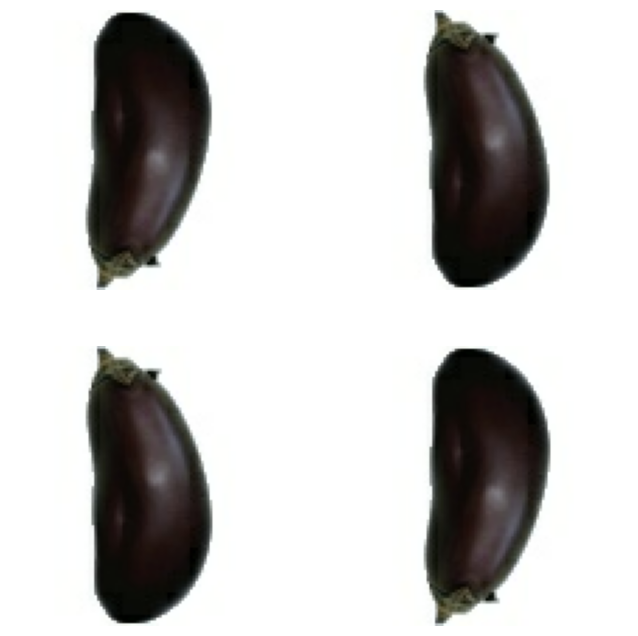

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_data.take(1):
    plt.figure(figsize=(8,8))
    first_image = image[0] #first image shape: (100,100,3)
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")  
        
# tf.expand_dims(first_image, 0) - Adds a batch dimension at the start. Shape becomes (1, 100, 100, 3). 
# since TensorFlow expects batches.

# data_augmentation() applies the random augmentation pipeline (e.g. RandomFlip, RandomRotation)

# Output shape remains (1, 100, 100, 3).
# Augmented_image[0] → single image again → shape (10, 10, 3).

### 5. Mobilenet v2 intro

Each model(mobilenet v2) comes with
* **model architecture**:
The base model has 155 layers that consist of conv layers, depthwise separable convolutions, inverted residual, bottleneck design, linear bottlenecks and squeeze and excitation blocks. 
<img src = "mobilenet2.png">

The model has 16 strides/blocks as below 
<img src="mobilenet1.png">
* **pretrained weights**
* **matching preprocessing function**: Preprocessing function prepares your images the same way they were prepared when the model was originally trained. MobileNetV2 was trained on ImageNet images that were preprocessed in a specific way.   
    For MobileNetV2, the preprocessing step:  
        - Converts pixel values from [0, 255] → [-1, 1]   
        - Ensures the color channels are in RGB order (not BGR)   

#### Mobilenet v2 architecture

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### 6. Transfer learning

- Take layers from a previously trained model.
- Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
- Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on the respective dataset.
- Train the new layers on your dataset.

Link: https://www.tensorflow.org/tutorials/images/transfer_learning

*include_top = **False*** argument load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.    
*layer.trainable = **False*** prevents the weights in a given layer from being updated during training

In [11]:
def fruits_classify_nn(image_shape = IMG_SIZE, data_augmentation=data_augmenter()):
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape,
                                                  include_top = False, # deleting the top layer with 1000 dense units (of original model)
                                                  weights = "imagenet")
    
    # freezing the base model
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape) #creating input layer
    
    x = data_augmentation(inputs) #augmented image will be stored in x
    x = preprocess_input(x) #preprocessed image will be stored in x
    x = base_model(x, training=False) #training = F to avoid tracking of stats by batch norm layer
    
    # Adding new classification layer
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2) (x)
    outputs = tfl.Dense(225, activation="softmax") (x)
    
    model = tf.keras.Model(inputs,outputs)
    
    return model

In [12]:
model1 = fruits_classify_nn(IMG_SIZE, data_augmentation) 

/var/folders/7w/y0zmsm413vv3zxql2vkprc8w0000gp/T/ipykernel_58330/2413915552.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape,


In [29]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 225)            │       288,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,583,781 (17.49 MB)

 Trainable params: 1,018,785 (3.89 MB)

 Non-trainable params: 1,527,424 (5.83 MB)

 Optimizer params: 2,037,572 (7.77 MB)

In [13]:
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [16]:
initial_epochs = 4

history = model1.fit(train_data, validation_data = validation_data, epochs = initial_epochs)

Epoch 1/4
2940/2940 ━━━━━━━━━━━━━━━━━━━━ 1043s 355ms/step - accuracy: 0.9751 - loss: 0.0874 - val_accuracy: 0.5641 - val_loss: 4.6339
Epoch 2/4
2940/2940 ━━━━━━━━━━━━━━━━━━━━ 1075s 366ms/step - accuracy: 0.9839 - loss: 0.0559 - val_accuracy: 0.6388 - val_loss: 3.7047
Epoch 3/4
2940/2940 ━━━━━━━━━━━━━━━━━━━━ 1201s 408ms/step - accuracy: 0.9852 - loss: 0.0517 - val_accuracy: 0.8292 - val_loss: 1.1838
Epoch 4/4
2940/2940 ━━━━━━━━━━━━━━━━━━━━ 1140s 388ms/step - accuracy: 0.9889 - loss: 0.0444 - val_accuracy: 0.8972 - val_loss: 0.6710


### Plotting training and validation accuracy

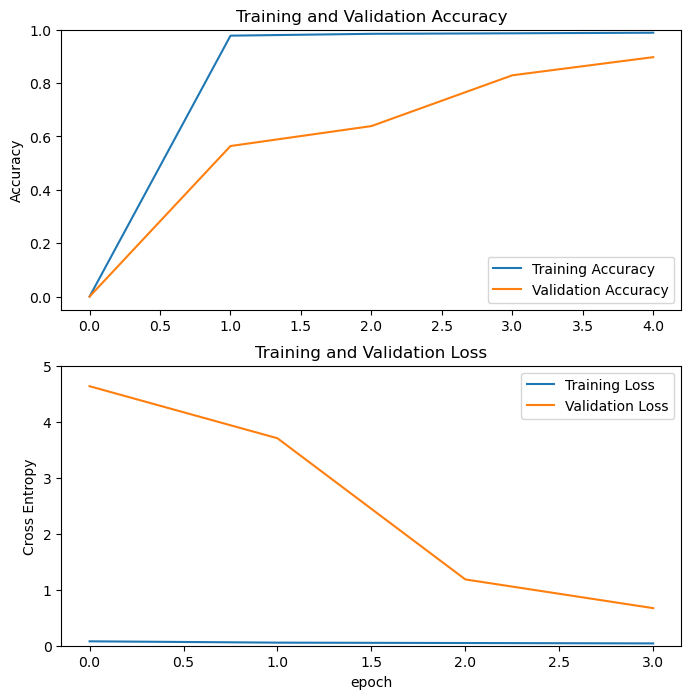

In [38]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
history.epoch[-1]

3

### 7. Fine tuning

- Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.Fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. 
- Use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. Adapting the learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data.
To achieve this, unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

In [19]:
for i, layer in enumerate(model1.layers):
    print(i, layer.name, layer.__class__.__name__)

0 input_layer_2 InputLayer
1 sequential Sequential
2 mobilenetv2_1.00_224 Functional
3 global_average_pooling2d GlobalAveragePooling2D
4 dropout Dropout
5 dense Dense


In [20]:
base_model = model1.layers[2]
base_model.trainable = True

print("Number of layers in base model: ", len(base_model.layers))

Number of layers in base model:  154


As we are training a much larger model and want to readapt the pretrained weights, 
it is important to use a lower learning rate at this stage. Otherwise, model could overfit very quickly.

In [21]:
#Fine-tune at this layer onwards
fine_tune_at = 145

#Freeze all the layers before the "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#Smaller learning rate to make the model to take smaller steps
l_r = 0.0001

#fine tuned model
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = l_r),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

In [22]:
fine_tune_epochs = 2

history_fine = model1.fit(train_data,
                         epochs=initial_epochs + fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_data)

Epoch 4/6
2940/2940 ━━━━━━━━━━━━━━━━━━━━ 258s 87ms/step - accuracy: 0.9971 - loss: 0.0098 - val_accuracy: 0.9998 - val_loss: 9.9252e-04
Epoch 5/6
2940/2940 ━━━━━━━━━━━━━━━━━━━━ 274s 93ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9999 - val_loss: 6.8820e-04
Epoch 6/6
2940/2940 ━━━━━━━━━━━━━━━━━━━━ 270s 92ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9999 - val_loss: 6.2114e-04


In [37]:
history_fine.history["accuracy"]

[0.998447835445404, 0.9995853900909424, 0.9997661113739014]

### Plotting training and validation accuracy - Fine tuned model

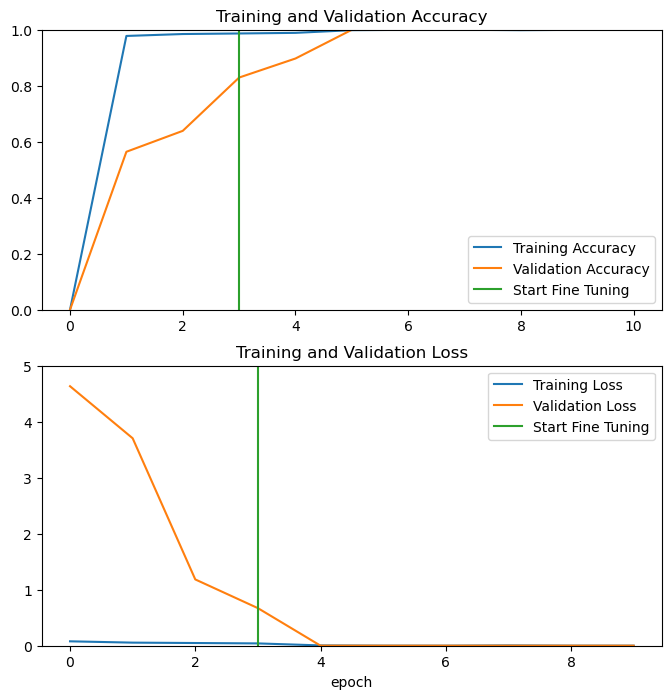

In [40]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Predicting the test data

In [41]:
test_data_path = "data/Test"
IMG_SIZE = (100,100)
BATCH_SIZE = 32 #number of images in a batch

test_data = image_dataset_from_directory(test_data_path, 
                                         batch_size=BATCH_SIZE, 
                                         image_size=IMG_SIZE, 
                                         shuffle=True,  
                                         seed=42)

Found 39212 files belonging to 225 classes.


In [42]:
loss, accuracy = model1.evaluate(test_data)
print("Test accuracy: ", accuracy)

1226/1226 ━━━━━━━━━━━━━━━━━━━━ 69s 56ms/step - accuracy: 0.9969 - loss: 0.0113
Test accuracy:  0.9967867136001587


In [58]:
images, labels = test_data.as_numpy_iterator().next()
y_pred = model1.predict_on_batch(images)

In [60]:
images.shape

(32, 100, 100, 3)

There are 32 images of size in the batch (100,100,3)

In [59]:
y_pred.shape

(32, 225)

Each 32 images has probabilities for 225 classes

In [62]:
predicted_class = y_pred.argmax(axis = 1)
print(predicted_class.shape)

(32,)


predicted_class has 32 class predictions

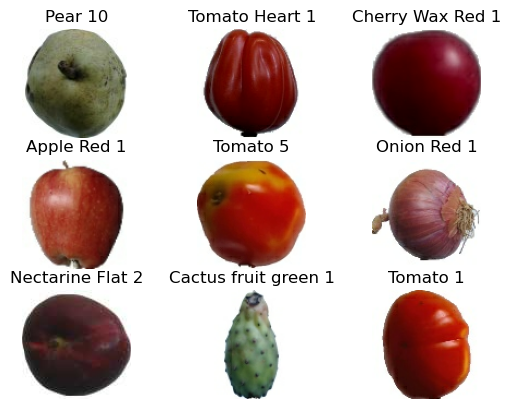

In [63]:
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[predicted_class[i]])
    plt.axis("off")

After fine-tuning few of the top layers in Mobilenetv2 model, th performance of the model is improved for fruits classification.   
After fine-tuning, the model learned high level features specific to fruit and vegetables dataset.  
The test accuracy of fine tuned model is 99.6 % 